# Single neuron Calcium Imaging

This notebook has the code to extract Calcium traces from the single neuron recordings on ZIM01.

In [1]:
#Unet
#import pckgs
import cv2
import tifffile as tiff
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import csv
import re
from numpy import unravel_index
import os
from natsort import natsorted
from imutils.src import imfunctions
import glob
from pathlib import Path
import shutil
import single_cell_imaging_functions_daniel as ca_image

Using TensorFlow backend.


### Option 1: Binarize using make_contour based binary

In [2]:
input_filepath='/scratch/zimmer/DanielM/zim01/BAG_RFP_max/2021-07-08_15-48-52_worm1_onfood-channel-0rfp_raw.btf'
output_filepath='/scratch/zimmer/DanielM/zim01/BAG_RFP_max/2021-07-08_15-48-52_worm1_onfood-channel-0rfp_raw_binary.btf'
median_blur=3
lt=140
ht=255
contour_size=2000
tolerance=0.5
area_to_fill=100
imfunctions.make_contour_based_binary(input_filepath, output_filepath, median_blur, lt, ht, contour_size, tolerance, area_to_fill)

In [3]:
#To check what areas the contour size and tolerance parameters give:
contour_size=500
tolerance=0.5
print(contour_size*(1-tolerance))
print(contour_size*(1+tolerance))

250.0
750.0


### Option 2: Binarize only with blur and threshold

In [4]:
input_filepath='/scratch/zimmer/DanielM/bag_zim_06/9.9/2021-09-06bag_zim06/btiffs/2021-09-06_19-05-32_worm4_on-channel-0-Andor3972bigtiff.btf'
output_filepath='/scratch/zimmer/DanielM/bag_zim_06/9.9/2021-09-06bag_zim06/btiffs/2021-09-06_19-05-32_worm4_on-channel-0-Andor3972bigtiff_binary.btf'
median_blur=3
lower_threshold=2000
higher_threshold=255
ca_image.binarize_btf(input_filepath,output_filepath,median_blur,lower_threshold,higher_threshold)

## option 1 for all worms

In [3]:
#apply the binarization
input_filepath=Path(r'/groups/zimmer/Daniel_Mitic/data/raw_data/bag_zim06/circular/zim06Bag_1cm_circle/cam1/btiffs_cam1/')
output_path=Path(r'/groups/zimmer/Daniel_Mitic/data/raw_data/bag_zim06/circular/zim06Bag_1cm_circle/cam1/btiffs_cam1/binary/')
median_blur=3
lower_threshold=2000
higher_threshold=255
for input_file in input_filepath.glob('*.btf'):
    
    
    #define new filename
    outputpath_filename=f'{output_path}/{input_file.stem}_binary.btf'
    
    
    #binarize
    ca_image.binarize_btf(input_file,outputpath_filename,median_blur,lower_threshold,higher_threshold)
print('done')

done


### check for camera alginment

In [4]:
rfp_filepath='/groups/zimmer/Daniel_Mitic/data/raw_data/bag_zim06/circular/zim06Bag_1cm_circle/2021-10-29_15-47-00_worm_1_0n_circle1cm-channel-1-Andor9046bigtiff.btf_test_misaligment.btf'
gcamp_filepath='/groups/zimmer/Daniel_Mitic/data/raw_data/bag_zim06/circular/zim06Bag_1cm_circle/cam2/btiffs_cam2/2021-10-29_15-47-00_worm_1_0n_circle1cm-channel-1-Andor9046bigtiff.btf'

/users/daniel.mitic/.conda/envs/openCV/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: TiffFile: the 'multifile' argument is ignored
  """Entry point for launching an IPython kernel.
/users/daniel.mitic/.conda/envs/openCV/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: TiffFile: the 'multifile' argument is ignored
  
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


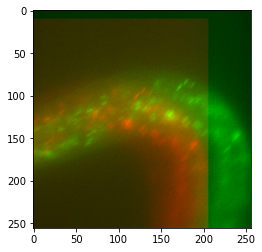

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


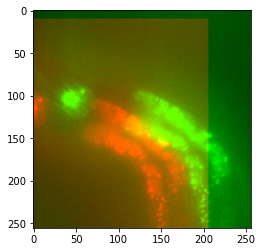

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


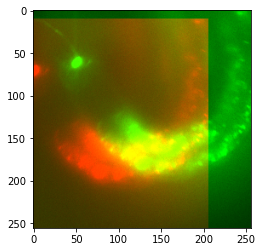

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


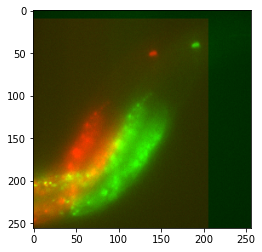

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


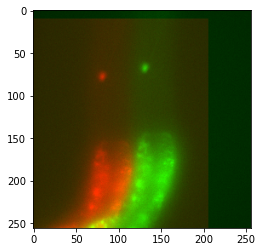

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


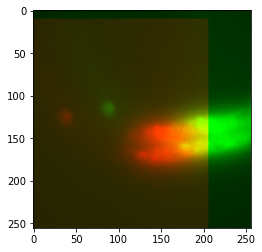

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


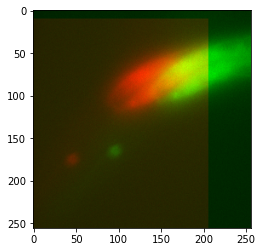

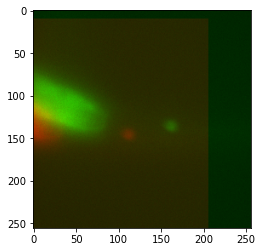

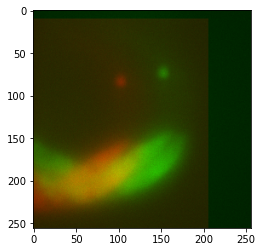

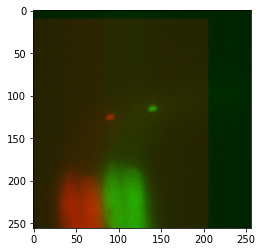

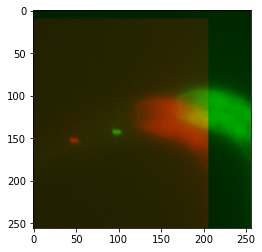

In [7]:
with tiff.TiffFile(rfp_filepath, multifile=True) as tif_rfp,\
    tiff.TiffFile(gcamp_filepath, multifile=False) as tif_gcamp:
    
    for i, page in enumerate(tif_rfp.pages):
            
            steps=int(len(tif_rfp.pages)*0.1)
            #displayes every 10th picture
            if i %steps==0:
                
                #read in form tiff as array
                gcamp=tif_gcamp.pages[i].asarray()
                rfp=tif_rfp.pages[i].asarray()
                
                #add color channels
                gcamp=cv2.cvtColor(gcamp, cv2.COLOR_GRAY2BGR)  
                rfp=cv2.cvtColor(rfp, cv2.COLOR_GRAY2BGR)
                
                #determine colors
                rfp[:, :, 1] = 0
                rfp[:, :, 2] = 0
                
                gcamp[:, :, 0] = 0
                gcamp[:, :, 2] = 0
                
    
                composite_pre_aligment=cv2.addWeighted(src1=gcamp,alpha=0.2,src2=rfp,beta=0.2,gamma=0)
                plt.imshow(composite_pre_aligment)
                plt.show()

/users/daniel.mitic/.conda/envs/openCV/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: TiffFile: the 'multifile' argument is ignored
  
/users/daniel.mitic/.conda/envs/openCV/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: TiffFile: the 'multifile' argument is ignored
  import sys


displacement x: 50
displacement y: -10


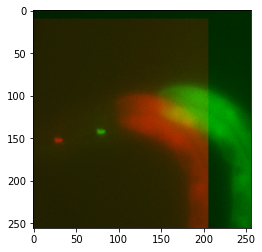

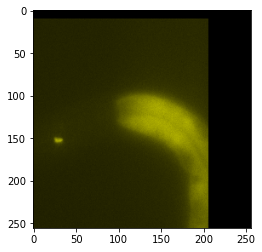

In [8]:

#needs to be divisible by size of array. if array lenght and with is even window must also be even. 
windwow_size=np.array([2,2])

all_global_maxima_difference=[]
            
with tiff.TiffFile(rfp_filepath, multifile=True) as tif_rfp,\
        tiff.TiffFile(gcamp_filepath, multifile=False) as tif_gcamp:
    
        for i, page in enumerate(tif_rfp.pages):
            
            steps=int(len(tif_rfp.pages)*0.01)
            
            if i %steps==0:
                
            #if i == 1834:
        
        
                
                gcamp=tif_gcamp.pages[i].asarray()
                rfp=tif_rfp.pages[i].asarray()
                
                slide_column=int(rfp.shape[1]/2)
                slide_row=int(rfp.shape[0]/2)
                
                
                
                #acalculate displacement 
                
                global_maxima=[]
                

                
    
                channels=[gcamp,rfp]



                for channel in channels:

                    #create matrix with means calculated via the window
                    
                    all_window_means=[]

                    for row in range(slide_row):
    
                        all_window_means_columns=[]
    
                        for column in range(slide_column):
        
                            window=channel[row*2:(row*2)+2, column*2:(column*2)+2]
                            window_mean=window.mean()
        
                            all_window_means_columns.append(window_mean)
                

        
                            #convert to list
                            all_window_means=list(all_window_means)
           
                        #append
                        all_window_means.append(all_window_means_columns)
    
                        #convert to array to find maxima
                        all_window_means=np.array(all_window_means)
            
    
                        #get index of maximal values
                        index_mean=np.array(unravel_index(all_window_means.argmax(), all_window_means.shape))

            
    
                    #recover original index
                    global_max_index=np.array(windwow_size*index_mean)
                    global_maxima.append(global_max_index)
    
            #calcualte displacement and store it in list
                
                global_maxima_difference=global_maxima[0]-global_maxima[1]
            
                all_global_maxima_difference.append(global_maxima_difference)
        
                #print(all_global_maxima_difference)
                
    
            #calcualte mean of displacement in x and y axis. 
                all_global_maxima_difference=np.array(all_global_maxima_difference)
            
                all_global_maxima_difference=list(all_global_maxima_difference)

        median_of_displacement=np.median(np.array(all_global_maxima_difference), axis=0)
        
         

            #
        displacement_y=int(median_of_displacement[0])
        displacement_x=int(median_of_displacement[1])
        
        #
        print('displacement x: '+str(displacement_x))
        print('displacement y: '+str(displacement_y))
        

        
        
        
        M = np.float32([[1, 0, -displacement_x], [0, 1, -displacement_y]])
        
        #transform it based on the transformation matrix
        shifted = cv2.warpAffine(gcamp, M, (gcamp.shape[1], gcamp.shape[0]))
        
        
        
        
        #add color channels (just for display purposes)
        gcamp=cv2.cvtColor(gcamp, cv2.COLOR_GRAY2BGR)  
        
        rfp=cv2.cvtColor(rfp, cv2.COLOR_GRAY2BGR)
        
        shifted_in_color=cv2.cvtColor(shifted, cv2.COLOR_GRAY2BGR)
                
        #determine colors
        rfp[:, :, 1] = 0
        rfp[:, :, 2] = 0
                
        gcamp[:, :, 0] = 0
        gcamp[:, :, 2] = 0
        
        shifted_in_color[:, :, 0] = 0
        shifted_in_color[:, :, 2] = 0
                
        
        composite_pre_aligment=cv2.addWeighted(src1=gcamp,alpha=0.2,src2=rfp,beta=0.2,gamma=0)
        plt.imshow(composite_pre_aligment)
        plt.show()
        
        
        composite_post_aligment=cv2.addWeighted(src1=shifted_in_color,alpha=0.2,src2=rfp,beta=0.2,gamma=0)
        
        plt.imshow(composite_post_aligment)
        plt.show()
            
            


        
        
            
        
        
        
        

In [113]:
shifted[1]

array([  0,   0,   0,   0, 153, 168, 159, 164, 163, 170, 163, 156, 149,
       156, 169, 166, 157, 161, 160, 175, 179, 161, 166, 160, 174, 171,
       165, 175, 172, 166, 169, 156, 164, 162, 171, 180, 158, 171, 176,
       180, 165, 174, 186, 157, 178, 165, 165, 186, 190, 157, 168, 173,
       182, 174, 169, 175, 162, 162, 177, 166, 187, 174, 175, 178, 170,
       165, 167, 163, 178, 169, 171, 182, 175, 176, 178, 182, 178, 175,
       173, 180, 172, 178, 173, 172, 176, 174, 182, 177, 184, 180, 188,
       172, 171, 178, 181, 183, 170, 189, 179, 176, 177, 192, 168, 188,
       177, 177, 178, 164, 190, 169, 178, 176, 179, 185, 176, 172, 187,
       164, 181, 175, 187, 190, 175, 171, 181, 183, 173, 168, 179, 173,
       172, 188, 192, 185, 179, 165, 179, 177, 185, 175, 167, 206, 187,
       177, 175, 183, 177, 182, 186, 173, 187, 193, 189, 181, 187, 185,
       183, 206, 184, 184, 170, 195, 174, 197, 173, 184, 195, 185, 178,
       191, 193, 189, 179, 190, 189, 202, 217, 219, 204, 186, 20

### Transform GCAMP Channel if needed
This will transform the GCAMP Channel in case the camera alignment was not good.

In [118]:
gcamp_filepath='/groups/zimmer/Daniel_Mitic/data/raw_data/bag_zim06/circular/zim06Bag_1cm_circle/cam2/btiffs_cam2/2021-10-29_15-47-00_worm_1_0n_circle1cm-channel-1-Andor9046bigtiff.btf'
output_filepath='/groups/zimmer/Daniel_Mitic/data/raw_data/bag_zim06/circular/zim06Bag_1cm_circle/2021-10-29_15-47-00_worm_1_0n_circle1cm-channel-1-Andor9046bigtiff.btf_test_misaligment.btf'

In [119]:
with tiff.TiffWriter(output_filepath, bigtiff=True) as tif_writer,\
    tiff.TiffFile(gcamp_filepath, multifile=False) as tif_gcamp:
    
    for i, page in enumerate(tif_gcamp.pages):
        
        img=page.asarray()
        
        #create the transformation matrix 
        M = np.float32([[1, 0, -50], [0, 1, 10]])
        
        #transform it based on the transformation matrix
        shifted = cv2.warpAffine(img, M, (img.shape[1], img.shape[0]))
        
        #flip if needed
        flipped = cv2.flip(shifted, 1)
        
        #save the processed Gcamp channel
        tif_writer.write(shifted, contiguous=True)

/users/daniel.mitic/.conda/envs/openCV/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: TiffFile: the 'multifile' argument is ignored
  


### calculate background intensity

In [31]:
rfp_mask_filepath='/scratch/zimmer/DanielM/bag_zim_06/circular/btiffs_cam1/binary/2021-09-29_18-36-37_worm2_on-channel-0-Andor3972bigtiff_binary.btf'
gcamp_filepath='/scratch/zimmer/DanielM/bag_zim_06/circular/btiffs_cam2/2021-09-29_18-36-37_worm2_on-channel-1-Andor9046bigtiff.btf'
rfp_filepath='/scratch/zimmer/DanielM/bag_zim_06/circular/btiffs_cam1/2021-09-29_18-36-37_worm2_on-channel-0-Andor3972bigtiff.btf'

#### for red channel

In [33]:
with tiff.TiffFile(rfp_mask_filepath, multifile=True) as tif_mask,\
        tiff.TiffFile(rfp_filepath, multifile=False) as tif_fluorescence:
    
        steps=int(len(tif_mask.pages)*0.1)
    
        for i, page in enumerate(tif_mask.pages):
            
            mask=tif_mask.pages[i].asarray()
            flourescence=tif_fluorescence.pages[i].asarray()
            
            if i %steps==0:
                #MABYE IMPROVE THIS FUNCTION TO TAKE A CERTAIN NUMBER OF RANDOM FRAMES
                rfp_background=ca_image.calculate_background(mask,flourescence)

/users/daniel.mitic/.conda/envs/openCV/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: TiffFile: the 'multifile' argument is ignored
  """Entry point for launching an IPython kernel.
/users/daniel.mitic/.conda/envs/openCV/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: TiffFile: the 'multifile' argument is ignored
  


#### for green channel

In [34]:
with tiff.TiffFile(rfp_mask_filepath, multifile=True) as tif_mask,\
        tiff.TiffFile(gcamp_filepath, multifile=False) as tif_fluorescence:
    
        steps=int(len(tif_mask.pages)*0.1)
    
        for i, page in enumerate(tif_mask.pages):
            
            mask=tif_mask.pages[i].asarray()
            fluorescence=tif_fluorescence.pages[i].asarray()
            
            if i %steps==0:
                
                gfp_background=ca_image.calculate_background(mask,fluorescence)

/users/daniel.mitic/.conda/envs/openCV/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: TiffFile: the 'multifile' argument is ignored
  """Entry point for launching an IPython kernel.
/users/daniel.mitic/.conda/envs/openCV/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: TiffFile: the 'multifile' argument is ignored
  


### calculate signal

#### for red channel

In [35]:
fluorescence_signal=[]
with tiff.TiffFile(rfp_mask_filepath, multifile=True) as tif_mask,\
    tiff.TiffFile(rfp_filepath, multifile=False) as tif_fluorescence:
    
    
    for i, page in enumerate(tif_fluorescence.pages):
    
        
            
        mask=tif_mask.pages[i].asarray()
        fluorescence=tif_fluorescence.pages[i].asarray()
            
        rfp=ca_image.calculate_signal(mask,fluorescence)
        
        fluorescence_signal.append(rfp)


rfp_background_corrected=np.array(fluorescence_signal.copy())-rfp_background

/users/daniel.mitic/.conda/envs/openCV/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: TiffFile: the 'multifile' argument is ignored
  
/users/daniel.mitic/.conda/envs/openCV/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: TiffFile: the 'multifile' argument is ignored
  This is separate from the ipykernel package so we can avoid doing imports until
/users/daniel.mitic/.conda/envs/openCV/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/users/daniel.mitic/.conda/envs/openCV/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


#### for green channel

In [36]:
fluorescence_signal=[]

with tiff.TiffFile(rfp_mask_filepath, multifile=True) as tif_mask,\
    tiff.TiffFile(gcamp_filepath, multifile=False) as tif_fluorescence:
    
    
    for i, page in enumerate(tif_fluorescence.pages):
        
        mask=tif_mask.pages[i].asarray()
        fluorescence=tif_fluorescence.pages[i].asarray()
            
        gfp=ca_image.calculate_signal(mask,fluorescence)
        
        fluorescence_signal.append(gfp)

gfp_background_corrected=np.array(fluorescence_signal.copy())-gfp_background


/users/daniel.mitic/.conda/envs/openCV/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: TiffFile: the 'multifile' argument is ignored
  This is separate from the ipykernel package so we can avoid doing imports until
/users/daniel.mitic/.conda/envs/openCV/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: TiffFile: the 'multifile' argument is ignored
  after removing the cwd from sys.path.


### calculate ratiometric signal

### plot the ratiometric signal

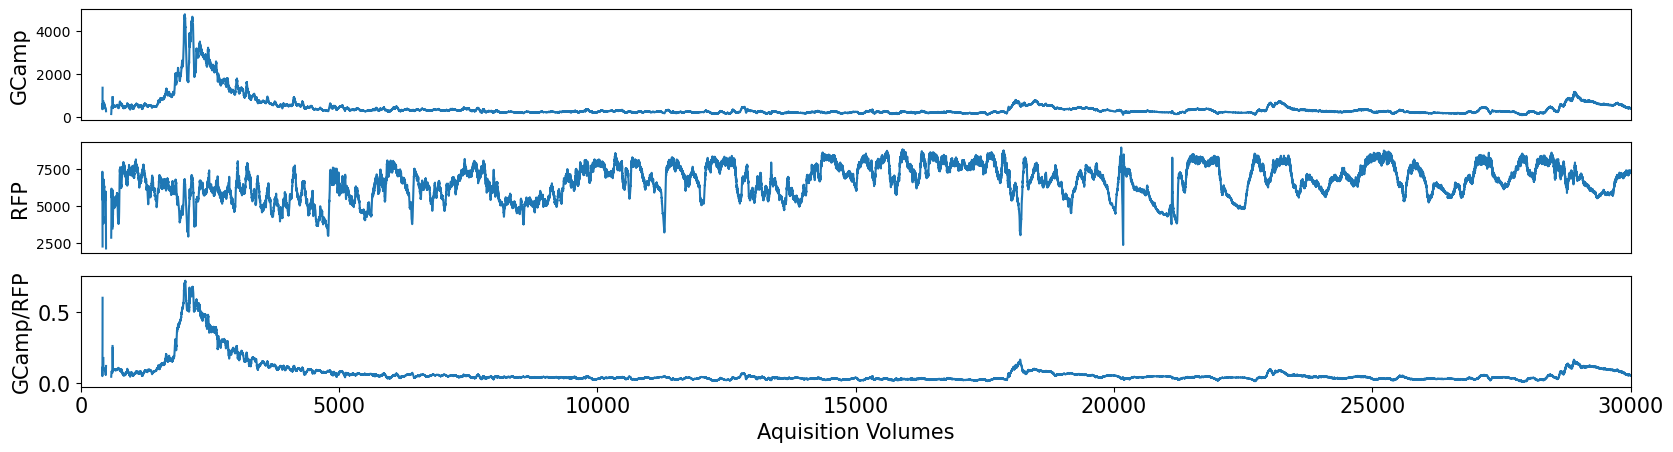

In [39]:
#plot signal
axes=ca_image.plot_gcamp_rfp_ratio(gfp_background_corrected,rfp_background_corrected)

#some modifications to the plot

for i,ax in enumerate(axes):
    ax.set_xlim([0, 30000])
    if i<2: 
        ax.set_xticks([])
        plt.yticks(fontsize=15)
    
    if i==2:
        #ax.tick_params(axis='x', labelrotation = 60)
        #ax.xaxis.set_ticks(np.arange(0, len(gfp_background_corrected), 500))
        #ax.set_ylim([0, 0.5])
        ax.set_xlabel('Aquisition Volumes',fontsize=15)
        ax.set_xlim([0, 30000])
        plt.xticks(fontsize=15)
        plt.yticks(fontsize=15)
        ax.tick_params(axis="x", labelsize=15)
        ax.tick_params(axis="y", labelsize=15)

### save the ratiometric signal as a csv

In [ ]:
ratiometric_signal=gfp/rfp
df=pd.DataFrame(ratiometric_signal)
#df.to_csv('/scratch/zimmer/DanielM/ratiometric_bagworm3.csv', index=None)
#df.plot()

### plot the ratiometric signal for all recordings

##### here i make lists containing paths to corresponding mask, rfp and gfp files

In [25]:
#make list of rfp path

rfp_path=Path(r'/scratch/zimmer/DanielM/bag_zim_06/circular/btiffs_cam1/')

rfp_path_list=[]
for file in natsorted(os.listdir(rfp_path)):
     if file.endswith('.btf'):
        rfp_filepath=f'{rfp_path}/{file}'
        rfp_path_list.append(rfp_filepath)


In [20]:
#make list of gfp path
gcamp_path=Path(r'/scratch/zimmer/DanielM/bag_zim_06/circular/btiffs_cam2/')
gcamp_path_list=[]
for file in natsorted(os.listdir(gcamp_path)):
     if file.endswith('.btf'):
        gcamp_filepath=f'{gcamp_path}/{file}'
        gcamp_path_list.append(gcamp_filepath)

In [21]:
#make list of rfp_mask path
rfp_path_mask=Path(r'/scratch/zimmer/DanielM/bag_zim_06/circular/btiffs_cam1/binary/')
rfp_path_mask_list=[]
for file in natsorted(os.listdir(rfp_path_mask)):
     if file.endswith('.btf'):
            mask_rfp_filepath=f'{rfp_path_mask}/{file}'
            rfp_path_mask_list.append(mask_rfp_filepath)
            
            

In [27]:
len(gcamp_path_list)

7

In [28]:
len(rfp_path_mask_list)

7

In [29]:
len(rfp_path_list)

7

132.49705505371094
131.62173461914062


/users/daniel.mitic/.conda/envs/openCV/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/users/daniel.mitic/.conda/envs/openCV/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


220.2914522056532
228.00029499584844


/users/daniel.mitic/.conda/envs/openCV/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/users/daniel.mitic/.conda/envs/openCV/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


112.92692565917969
118.61381530761719


/users/daniel.mitic/.conda/envs/openCV/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/users/daniel.mitic/.conda/envs/openCV/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


582.6973567335802
225.9564887502338


/users/daniel.mitic/.conda/envs/openCV/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/users/daniel.mitic/.conda/envs/openCV/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


140.38327026367188
135.80050659179688


/users/daniel.mitic/.conda/envs/openCV/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/users/daniel.mitic/.conda/envs/openCV/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


139.80532836914062
139.03367614746094


/users/daniel.mitic/.conda/envs/openCV/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/users/daniel.mitic/.conda/envs/openCV/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


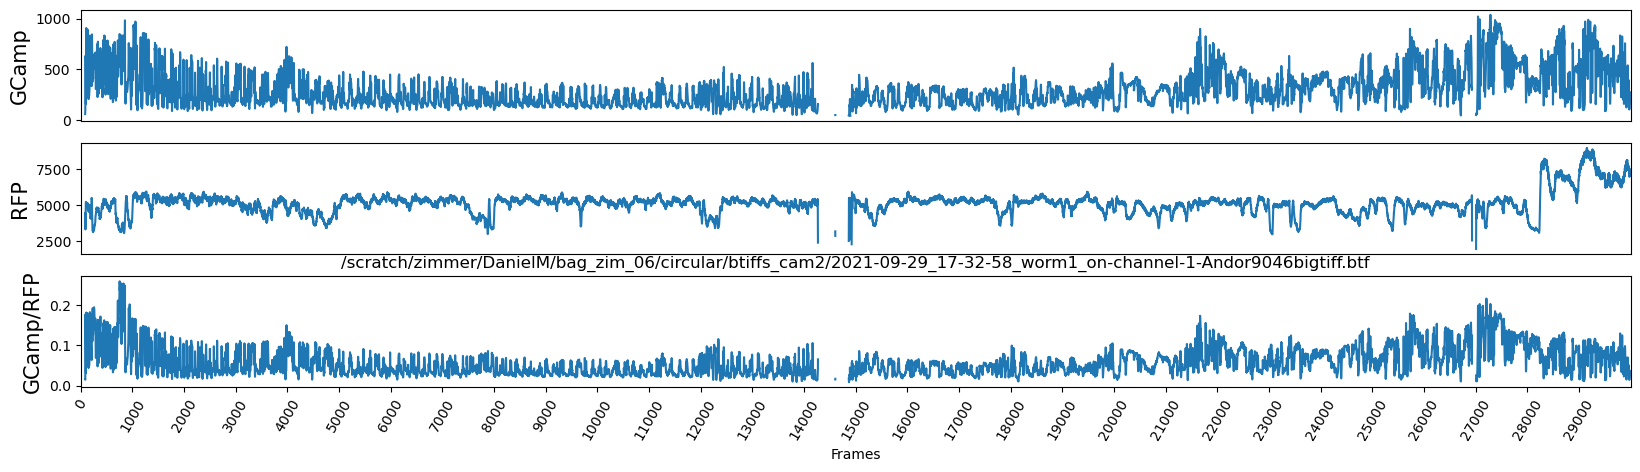

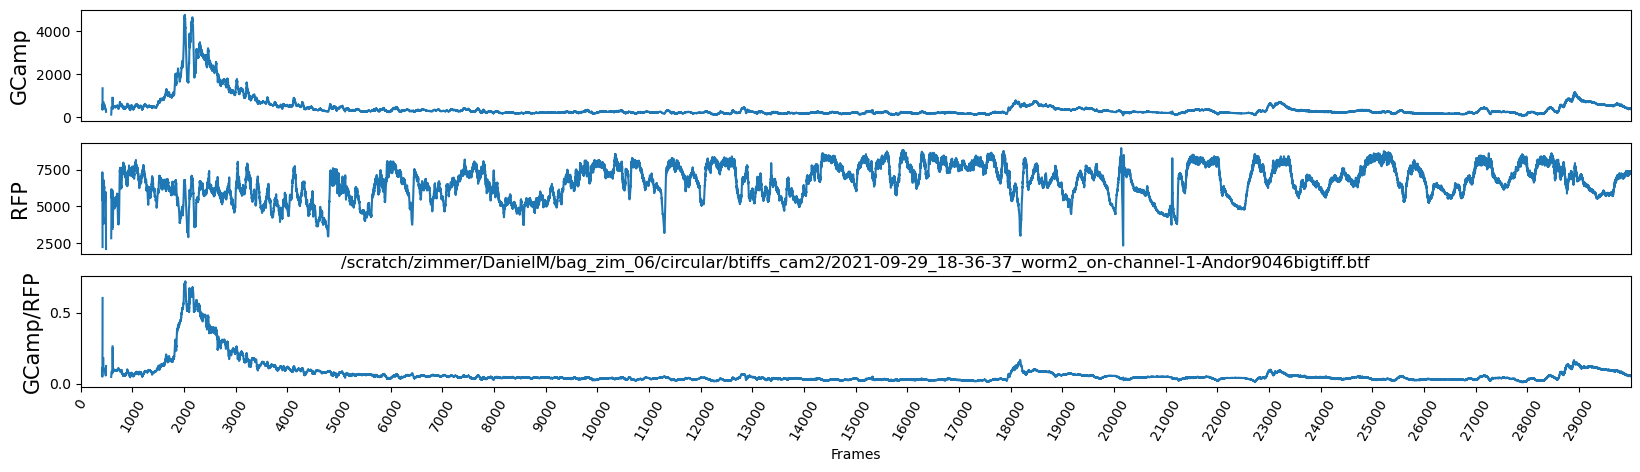

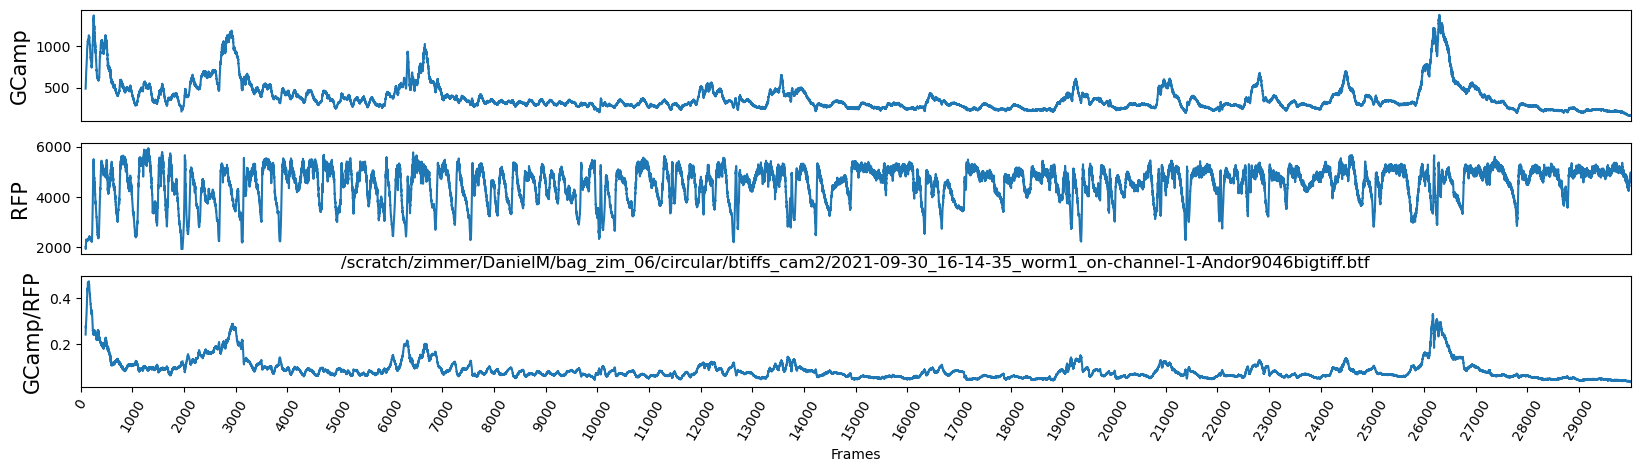

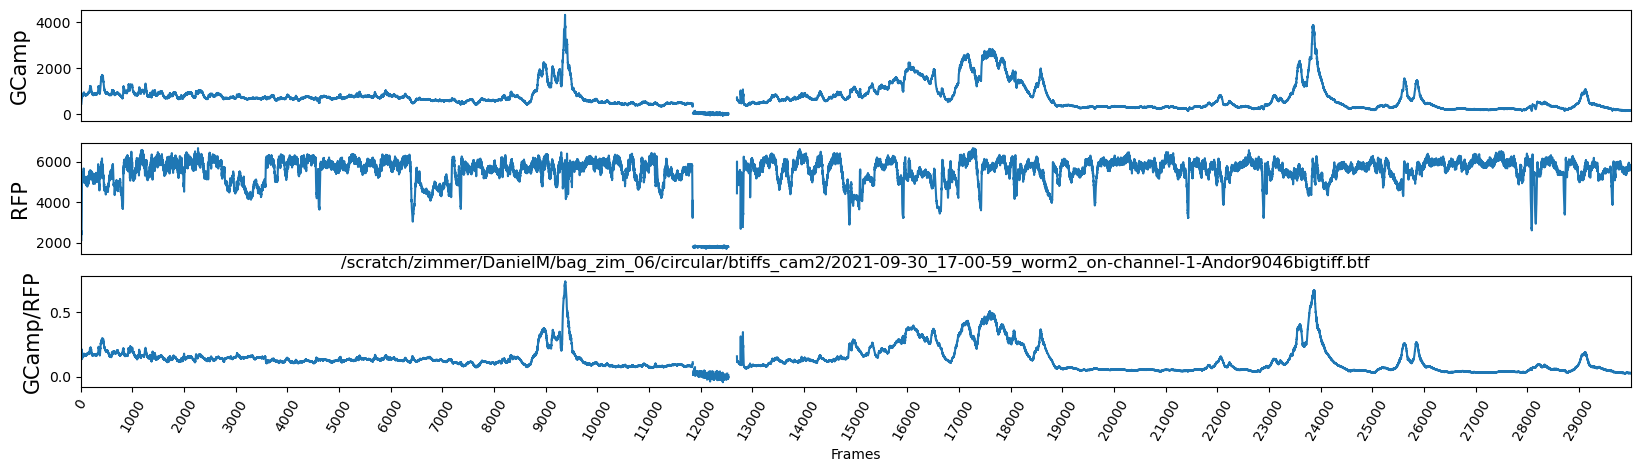

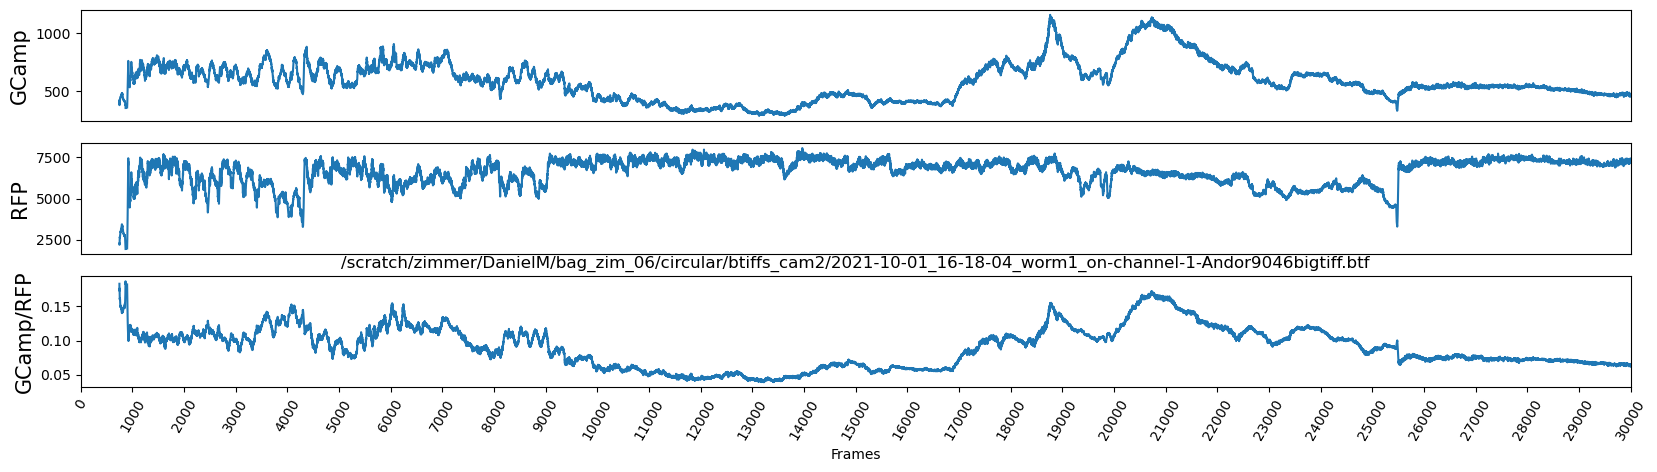

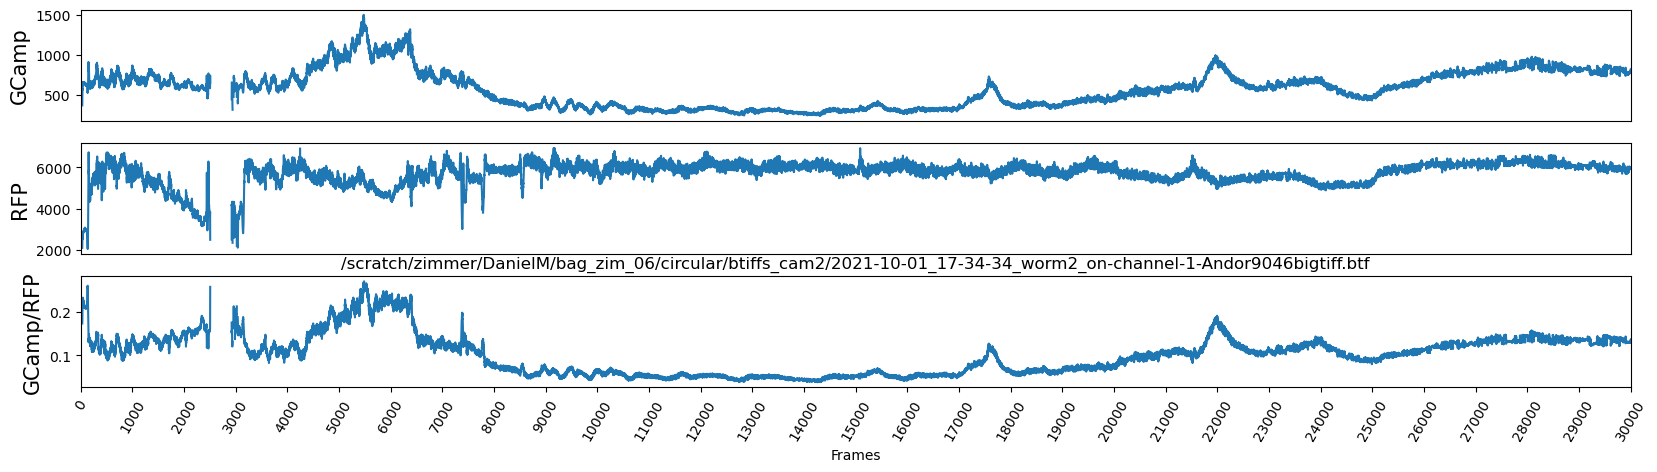

In [46]:
for idx in range(len(gcamp_path_list)-1):
    
    #get paths
    
    gcamp_filepath=gcamp_path_list[idx]
    rfp_filepath=rfp_path_list[idx]
    rfp_mask_filepath=rfp_path_mask_list[idx]
    
    #calculate background intensity
    background_gfp,background_rfp=ca_image.calculate_background_2(rfp_mask_filepath,rfp_filepath,gcamp_filepath)
    print(background_gfp)
    print(background_rfp)
    #calculate signal
    gcamp_signal, rfp_signal=ca_image.calculate_signal_2(rfp_mask_filepath,rfp_filepath,gcamp_filepath,background_gfp,background_rfp)
    
    #plot
    axes=ca_image.plot_gcamp_rfp_ratio(gcamp_signal,rfp_signal)

    #some modifications to the plot
    #axes[0].set_ylim([0,30])
    for i,ax in enumerate(axes):
        ax.set_xlim([0, 30000])
        if i<2: 
            ax.set_xticks([])
        if i==2:
            ax.tick_params(axis='x', labelrotation = 60)
            ax.xaxis.set_ticks(np.arange(0, len(gcamp_signal), 1000))
            #ax.set_ylim([0, 0.7])
            ax.set_xlabel('Frames')
    plt.title(gcamp_path_list[idx])

### save ratiometric signal for all recordings

In [43]:
output_path='/groups/zimmer/Daniel_Mitic/data/'

In [44]:
all_gfp_background=[]
all_rfp_background=[]
for idx in range(len(gcamp_path_list)-1):
    
    #get paths
    
        gcamp_filepath=gcamp_path_list[idx]
        rfp_filepath=rfp_path_list[idx]
        rfp_mask_filepath=rfp_path_mask_list[idx]
    
        #calculate background intensity
        background_gfp,background_rfp=ca_image.calculate_background_2(rfp_mask_filepath,rfp_filepath,gcamp_filepath)
        
        
        
        
    
        #calculate signal
        gcamp_signal, rfp_signal=ca_image.calculate_signal_2(rfp_mask_filepath,rfp_filepath,gcamp_filepath,background_gfp,background_rfp)
        ratiometric_signal=gcamp_signal/rfp_signal
        
        # add background
        background_gfp=np.repeat(background_gfp, len(gcamp_signal))
        background_rfp=np.repeat(background_rfp, len(rfp_signal))
        
        #get new file name
        before,sep,after=gcamp_path_list[idx].partition('2021')
        new_file_name=sep+after+'traces.csv'
        
        #create dataframe
        df = pd.DataFrame({'gcamp': gcamp_signal, 'rfp': rfp_signal,'ratiometric':ratiometric_signal,'background_rfp':background_rfp,'background_gfp':background_gfp})
        
        #save
        df.to_csv(output_path+new_file_name, index=None)
    

In [28]:
ratiometric_signal=gcamp_signal/rfp_signal
df = pd.DataFrame({'gcamp': gcamp_signal, 'rfp': rfp_signal,'ratiometric':ratiometric_signal})

In [50]:
output_path+new_file_name

'/groups/zimmer/Daniel_Mitic/data/single_cell_calcium_imaging_bag_zim443/bag_raw/traces/2021-07-20_17-24-55_bagworm5on-channel-1.btftraces.csv'

In [ ]:
plt.hist(gcamp[roi])
plt.hist(gcamp[roi2])

(array([38., 34., 26., 23., 17.,  4.,  0.,  1.,  0.,  1.]),
 array([301. , 320.6, 340.2, 359.8, 379.4, 399. , 418.6, 438.2, 457.8,
        477.4, 497. ]),
 <a list of 10 Patch objects>)

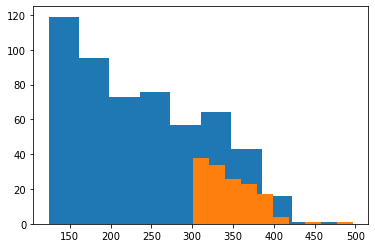

In [162]:
plt.hist(rfp[roi])
plt.hist(rfp[roi2])


In [157]:
#convert list to numpy array
gcamp_signal=np.array(gcamp_signal)
rfp_signal=np.array(rfp_signal)


In [40]:
#remove background (TODO: improve background calculation)
gcamp_signal=gcamp_signal-104
rfp_signal=rfp_signal-104

In [76]:
#find frames where there is no signal
np.where(np.isnan(gcamp_signal))

(array([ 288,  289,  290, ..., 9980, 9981, 9982]),)

In [77]:
#check % of frames without signal
np.isnan(gcamp_signal).sum()/gcamp_signal.shape[0]

0.3439847741159972

### Stack Subsampling

For instance the behaviour to have same number of frames as max projections (default is number of frames == total number of planes)

In [41]:
input_filepath='/scratch/zimmer/DanielM/bag_zim_06/9.9/2021-09-06bag_zim06/btiffs/2021-09-06_19-05-32_worm4_on-channel-1-Andor9046bigtiff.btf'
output_filepath='/scratch/zimmer/DanielM/bag_zim_06/9.9/2021-09-06bag_zim06/btiffs/2021-09-06_19-05-32_worm4_on-channel-1-Andor9046bigtiff_subsampled.btf'
with tiff.TiffFile(input_filepath, multifile=False) as tif,\
 tiff.TiffWriter(output_filepath, bigtiff=True) as tif_writer:
    for i, page in enumerate(tif.pages):
        if i %6==0:
            img=page.asarray()
            tif_writer.write(img,contiguous=True)
            

/users/daniel.mitic/.conda/envs/openCV/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: TiffFile: the 'multifile' argument is ignored
  This is separate from the ipykernel package so we can avoid doing imports until
